# Final Model for Objective 2

### Data Collection

In [1]:
import os 
import sys 
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
# Pytorch module 
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import random
from typing import Any, Mapping
from time import gmtime, strftime

# set working directory
os.chdir('/home/jovyan/contrails/contrails_detection/')

# Project Module
import config
import src.utils as utils
from src.dataset import ContrailsDataset
from src.model import BaseUnet, SegmentLightning, AttentionUNet, UNetPlus
from src.train import Trainer
from src.trainer_lgt import TrainerLightning

## Tensorboard Modules
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Memory management
def clear_torch_cache():
    torch.cuda.empty_cache()
    print("Cleared PyTorch GPU cache.")

# Run the function to clear GPU cache
clear_torch_cache()

!nvidia-smi

Cleared PyTorch GPU cache.
Wed Aug 14 12:58:18 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.116.03   Driver Version: 525.116.03   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A4000    Off  | 00000000:03:00.0 Off |                  Off |
| 41%   42C    P8     7W / 140W |    682MiB / 16376MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                             

In [2]:
## Load file from csv split into train/test
from sklearn.model_selection import train_test_split
df = pd.read_csv(config.CSV_TRAIN_REC, index_col=0)
train_df, valid_df = train_test_split(df[df.Class.isin([0,1])], test_size = .2, random_state=42)
train_df.head()

,Image_ID,Class
16081,8975896718947475053,0
17494,2887461863286016746,0
15040,1323985642378913441,1
7528,8578962451401293377,0
18488,1733973341297589475,1


### Pytorch data prepration

In [3]:
torch.manual_seed(44)
transform = transforms.Compose([
    # Add your desired transformations here
    transforms.ToTensor(),
    #transforms.Lambda(lambda x: x/255.0),
    #transforms.Lambda(lambda x: utils.get_rgb(x)),
    transforms.Lambda(lambda x: utils.compute_TDi_ashrgb(x, -5)),
                      ])


train_dataset = ContrailsDataset(dataframe=train_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                 sequence_index=config.TS # nth:5 sequence image
                                )

## Data Loaders
train_dataloader = DataLoader(train_dataset,
                              batch_size=4,
                              shuffle=True,
                              num_workers=config.WORKERS,
                              pin_memory=True,
                              prefetch_factor=config.WORKERS,
                             )

## Validation Dataloader 
valid_dataset = ContrailsDataset(dataframe=valid_df,
                                 root_dir=config.DATA_DIR+'train',
                                 transform=transform,
                                 sequence_index=config.TS
                                )

valid_dataloader = DataLoader(valid_dataset,
                              batch_size=4,
                              shuffle=False,
                              num_workers=config.WORKERS,
                              prefetch_factor=config.WORKERS
                             )

In [4]:
t_image, t_mask = next(iter(train_dataloader))
print(len(train_dataloader))
t_image.shape, t_mask.shape

4106


(torch.Size([4, 5, 256, 256]), torch.Size([4, 1, 256, 256]))

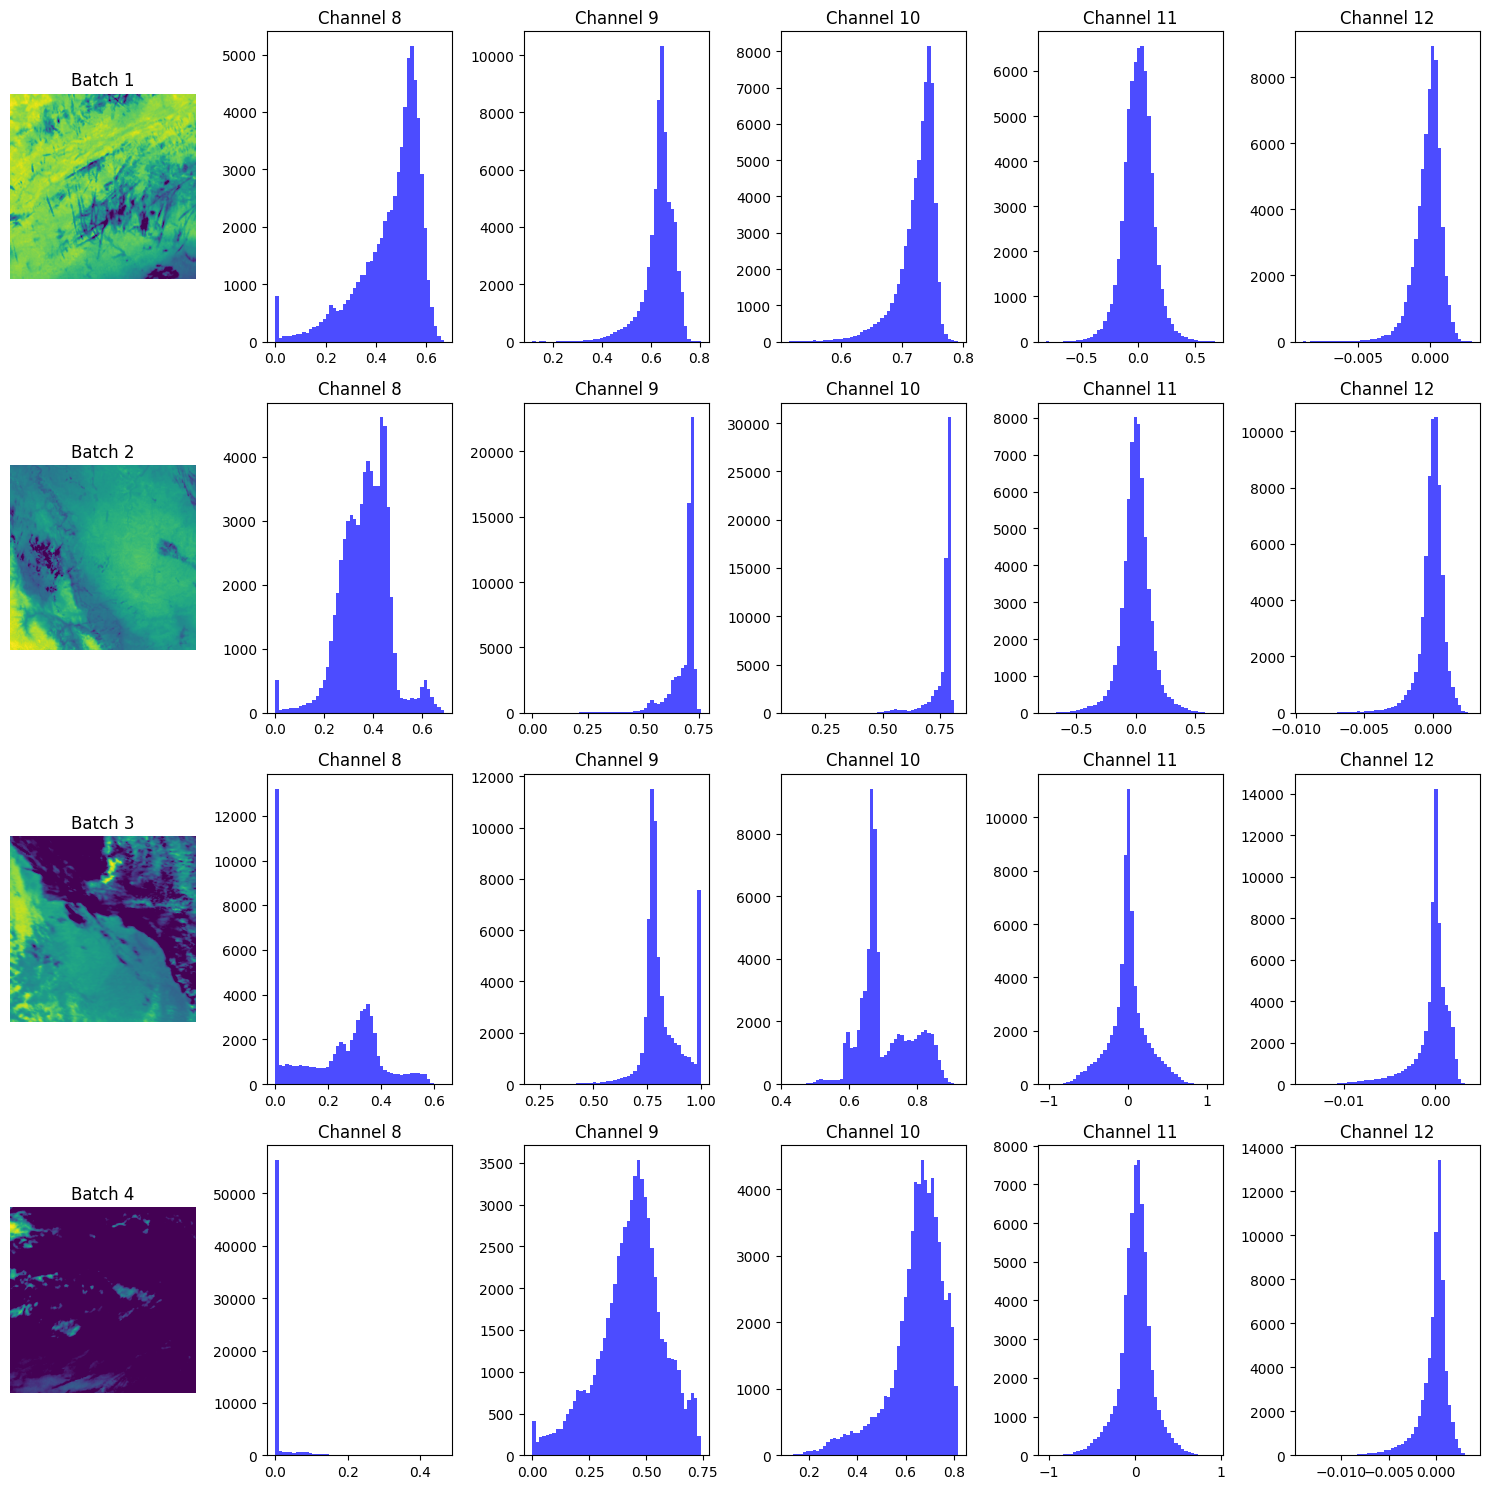

In [12]:
utils.plot_batch_histogram(t_image)

## Model Building: U-Net, with AshRGB input 

In [17]:
## Loss function
class TverskyLoss(torch.nn.Module):
    def __init__(self, alpha=0.3, beta=0.7):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, inputs, targets):
        smooth = 1.0
        inputs = torch.sigmoid(inputs)
        true_pos = torch.sum(targets * inputs)
        false_neg = torch.sum(targets * (1 - inputs))
        false_pos = torch.sum((1 - targets) * inputs)
        return 1 - (true_pos + smooth) / (true_pos + self.alpha * false_neg + self.beta * false_pos + smooth)

In [3]:
## Training Parameters
IN_CHNL = t_image.shape[1]
OUT_CHNL = t_mask.shape[1]
dropout=0.2
features = [64, 128, 256, 512]
learning_rate = 1e-5
model_final = UNetPlus(in_channels=IN_CHNL, out_channels=OUT_CHNL, features=features, dropout_prob=dropout)
main_model = model_final.to(config.DEVICE)

NameError: name 't_image' is not defined

In [31]:
_expr_name = "UNetPlus"
tb_path = "tb_log/OBJ2_Final"
logger = pl.loggers.TensorBoardLogger(tb_path, name=_expr_name)
# Criterion
criterion = TverskyLoss()
# Gradient clipping
torch.nn.utils.clip_grad_norm_(main_model.parameters(), max_norm=1.0)
# Scheduler
scheduler_name = 'ReduceLROnPlateau'
scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}

In [32]:
# Training Model
lgt_o2model = SegmentLightning(
            model=main_model,
            criterion=criterion,
            learning_rate=learning_rate,
            scheduler_name=scheduler_name,
            scheduler_params=scheduler_params,
            train_dataset=train_dataset,
            val_dataset=valid_dataset,
            batch_size=4
        )
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)
checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=f'./model_checkpoints/OBJ2_FINAL/' +_expr_name,
            monitor="val_loss",
            save_last=True,
            save_top_k=5
        )

In [ ]:
torch.cuda.empty_cache()
trainer = pl.Trainer(
            max_epochs=50,
            logger=logger,
            precision=config.PRECISION,
            accelerator=config.ACCELERATOR,
            devices=[0],
            min_epochs=1,
            callbacks=[checkpoint_callback, early_stop_callback],
        )
trainer.fit(lgt_o2model)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type         | Params
--------------------------------------------------
0 | model            | UNetPlus     | 31.0 M
1 | criterion        | TverskyLoss  | 0     
2 | iou              | JaccardIndex | 0     
3 | dice_coefficient | Dice         | 0     
--------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
62.087    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## Model: UNet++ model, with TDi and AshRGB 

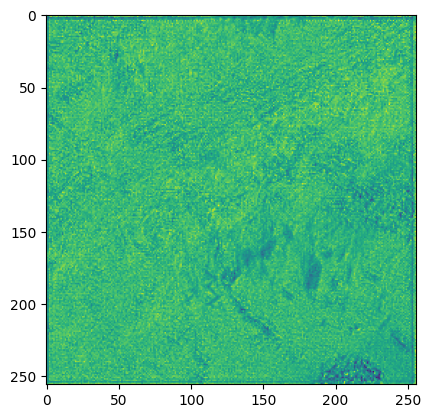

In [15]:
IN=5
OUT=1
FEATURE=[64, 128, 256, 512]
PROB_D =0.15
LR = 1e-5
model_tune_upp = UNetPlus(in_channels=IN, out_channels=OUT, features=FEATURE, dropout_prob=PROB_D)
pred_s = model_tune_upp(t_image)
pred_s.shape 

plt.imshow(pred_s[0,0, :, :].detach().numpy())

In [19]:
_expr_name = "UNetPlus_Gauss_Tune"
tb_path = "tb_log/OBJ2_Final"
logger = pl.loggers.TensorBoardLogger(tb_path, name=_expr_name)

In [20]:
# Criterion
tr_model = model_tune_upp.to(config.DEVICE)
criterion = TverskyLoss()
# Gradient clipping
torch.nn.utils.clip_grad_norm_(tr_model.parameters(), max_norm=1.0)
# Scheduler
scheduler_name = 'ReduceLROnPlateau'
scheduler_params = {'factor': 0.1, 'patience': 3, 'min_lr': 1e-6}

# Training Model
lgt_bbmodel = SegmentLightning(
            model=tr_model,
            criterion=criterion,
            learning_rate=LR,
            scheduler_name=scheduler_name,
            scheduler_params = scheduler_params,
            train_dataset=train_dataset,
            val_dataset=valid_dataset,
            batch_size=8
        )
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model_chkp = f'./model_checkpoints/OBJ2_FINAL/{_expr_name}'
checkpoint_callback = pl.callbacks.ModelCheckpoint(
            dirpath=model_chkp,
            monitor="val_loss",
            save_last=True,
            save_top_k=5
        )

In [ ]:
torch.cuda.empty_cache()
trainer = pl.Trainer(
            max_epochs=50,
            logger=logger,
            precision=config.PRECISION,
            accelerator=config.ACCELERATOR,
            devices=[0],
            min_epochs=1,
            callbacks=[checkpoint_callback, early_stop_callback],
        )
trainer.fit(lgt_bbmodel)

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: tb_log/OBJ2_Final/UNetPlus_Gauss_Tune
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type         | Params
--------------------------------------------------
0 | model            | UNetPlus     | 31.0 M
1 | criterion        | TverskyLoss  | 0     
2 | iou              | JaccardIndex | 0     
3 | dice_coefficient | Dice         | 0     
--------------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
62.089    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]